In [2]:
import re
import matplotlib.pyplot as plt
import os

In [3]:
import pandas as pd
import requests
from datetime import datetime
import concurrent.futures

In [4]:
# path to your specola database archive csv file, for more info visit:
# https://sunspots.irsol.usi.ch/db/choose-dl-year.php
specola_data_csv_file_path = './sunspot_data_excel.csv'

df = pd.read_csv(specola_data_csv_file_path)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
solar_maximum_years = [1958,1968,1980, 1990, 2001, 2014]
solar_minimum_years = [1964,1976, 1986, 1996, 2008]

In [6]:
avg_calculation_for_abstarct = []
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Filter out rows where 'group nr.' is NaN or contains letters
# Group number of NAN indicates data wasnt available on that day/time
# Group number with letters indicates the observers were unsure if the sunspot was part of a particular group
df = df[df['group nr.'].notna() & df['group nr.'].apply(lambda x: re.match(r'^\d+$', str(x)) is not None)]

# Unique list of years in the dataset
years = sorted(df['year'].unique())

# Initialize a dictionary to store the average lifespan by year
average_lifespan_by_year = {}

for year in years:
    # Filter the DataFrame for the current year
    df_year = df[df['year'] == year]

    # Initialize a dictionary to track the days the sunspot groups appear for the current year
    group_dates = {}

    # Process each row -> looping through the current year and doing operations one row at a time
    for index, row in df_year.iterrows():
        group_number = row['group nr.']
        date_obj = row['date']

        # If group is seen for the first time, initialize a list in the dictionary
        if group_number not in group_dates:
            group_dates[group_number] = []

        # Append the date to the list of appearances
        group_dates[group_number].append(date_obj)

    # Checks for potential overlaps by comparing the last two months of the current year
    # with the first two months of the next year. This can be extended to however many months you wish to filter
    if year + 1 in years:
        df_current_last_two_months = df[(df['year'] == year) & (df['month'] >= 11)]
        df_next_first_two_months = df[(df['year'] == year + 1) & (df['month'] <= 2)]

        for index, row in df_current_last_two_months.iterrows():

            group_number = row['group nr.'] #802
            # Check if this group also appears in the next year's first two months
            df_next_group = df_next_first_two_months[df_next_first_two_months['group nr.'] == group_number]

            if not df_next_group.empty:
                #UNCOMMENT FOR DEBUG PURPOSES
                # print("this group appears in the next year {}".format(df_next_group['group nr.']))

                latest_next_year_date = df_next_group['date'].max()
                #UNCOMMENT FOR DEBUG PURPOSES
                # print("latest appearance of the group in the next year is: {}".format(latest_next_year_date))
                if latest_next_year_date > group_dates[str(group_number)][-1]:
                    group_dates[str(group_number)].append(latest_next_year_date)
                    #UNCOMMENT FOR DEBUG PURPOSES
                    # print(group_dates[str(group_number)])

    # Calculate the lifespan for each group in the current year
    life_span_by_group = {}
    total_lifespan = 0
    for group, dates in group_dates.items():
        min_date = min(dates)
        max_date = max(dates)
        lifespan = (max_date - min_date).days + 1
        total_lifespan += lifespan
        life_span_by_group[group] = lifespan

    # print(f"year: {year}, lifespan: {lifespan}, total: {len(life_span_by_group)}")
    average_lifespan_by_year[year] = total_lifespan / len(life_span_by_group)
    

data_to_csv = {
    'Year': [],
    'Specola Avg Lifespan (days)': [],
    'Fenyi Avg Lifespan (days)':[],
    'Phase':[],
    '% Change Specola':[],
    '% Change Fenyi': []
}

# Output the average lifespan for each year
test_min = []
test_max = []
for year, avg_lifespan in sorted(average_lifespan_by_year.items()):
    # print(f"The average lifespan of sunspot groups in {year} is {avg_lifespan:.2f} days.")
    
    if year in solar_maximum_years and year >= 1974:
        data_to_csv['Year'].append(year)
        data_to_csv['Specola Avg Lifespan (days)'].append(round(avg_lifespan,2))
        data_to_csv['Phase'].append("Maximum")
    elif year in solar_minimum_years and year >= 1974:
        data_to_csv['Year'].append(year)
        data_to_csv['Specola Avg Lifespan (days)'].append(round(avg_lifespan,2))
        data_to_csv['Phase'].append("Minimum")

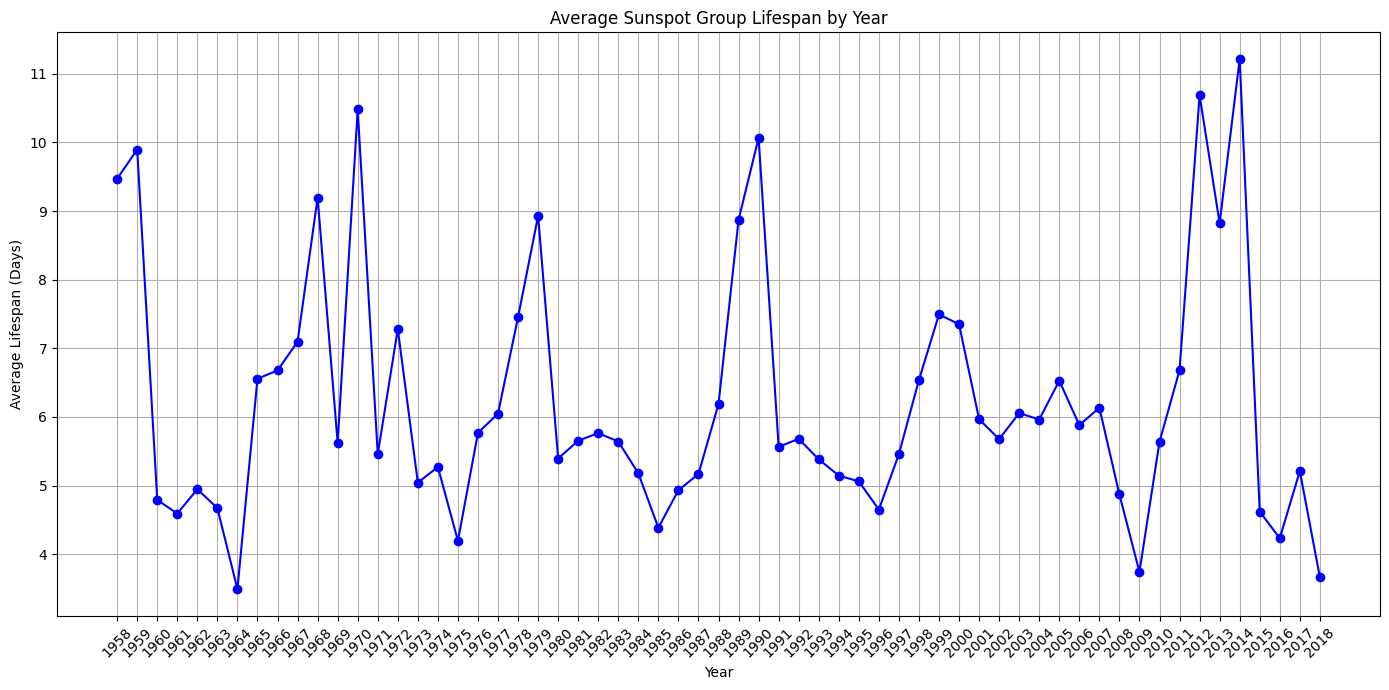

In [7]:
# Convert the years in average_lifespan_by_year to strings
average_lifespan_by_year_str = {str(year): value for year, value in average_lifespan_by_year.items()}

list_of_years = ['1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', 
                 '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', 
                 '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', 
                 '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', 
                 '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', 
                 '2018']

# Initialize a list with values corresponding to list_of_new_years
life_span_values_list = []
for year in list_of_years:
    if year in average_lifespan_by_year_str:
        life_span_values_list.append(average_lifespan_by_year_str[year])
    else:
        life_span_values_list.append(0)
        
# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(list_of_years, life_span_values_list, marker='o', linestyle='-', color='b')
plt.title('Average Sunspot Group Lifespan by Year')
plt.xlabel('Year')
plt.ylabel('Average Lifespan (Days)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
######################################## FENYII DATABASE #############################################

In [9]:
# this list contatins the years where we want to gather the data
list_of_years = ['1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

In [10]:
def retrieve_and_process_data(year):
    
    url = f"http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/data/DPD{year}.txt"
    
    response = requests.get(url)

    if response.status_code == 200:
        content = response.text
        lines = content.splitlines()

        group_dates = {}

        for line in lines:
            if line.startswith('g'):
                columns = line.split()
                
                # Extract the group number (it's in the 7th position after removing whitespaces)
                group_number = columns[7]
                
                try:
                    int_conversion_of_group_number = int(group_number)
                except ValueError:
                    continue

                # Construct the date from the year, month, and day in the line
                date_str = f"{columns[1]}-{columns[2]}-{columns[3]}"
                date_obj = datetime.strptime(date_str, '%Y-%m-%d')

                # If the group number is not in the dictionary, add it with an empty list
                if group_number not in group_dates:
                    group_dates[group_number] = []

                # Append the date to the list for this group number
                group_dates[group_number].append(date_obj)
                
        last_two_months_groups = {group: dates for group, dates in group_dates.items() if any(d.month >= 11 for d in dates)}
        
        # Load data from the next year to check for overlaps
        next_year = int(year) + 1
        nextt_year = str(next_year)
        
        url_next_year = f"http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/data/DPD{nextt_year}.txt"
        response_next_year = requests.get(url_next_year)
        
        if response_next_year.status_code == 200:
            content_next_year = response_next_year.text
            lines_next_year = content_next_year.splitlines()

            for line in lines_next_year:
                if line.startswith('g'):
                    columns = line.split()
                    group_number = columns[7]
                    
                    try:
                        int_conversion_of_group_number = int(group_number)
                    except ValueError:
                        continue

                    date_str = f"{columns[1]}-{columns[2]}-{columns[3]}"
                    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
                    
                    # Only consider dates in January and February of the next year
                    if date_obj.month <= 2 and group_number in last_two_months_groups:
                        group_dates[group_number].append(date_obj)
                        
        return group_dates
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")
        return 0

def calculate_group_durations(group_dates):
    group_durations = {}
    
    for group, dates in group_dates.items():
        if dates:
            # Find the duration between the first and last date
            min_date = min(dates)
            max_date = max(dates)
            duration = (max_date - min_date).days + 1  # Including both start and end dates
            
            group_durations[group] = duration

    return group_durations

def find_avg_days_between_all_sunspots(year):
    all_group_dates = {}
    # list with all the sunspot groups and the date they appear
    year_group_dates = retrieve_and_process_data(year)
    if year_group_dates == 0:
        print('exiting because retrive_and_process data returned an error for year: '+year)
        return 0
    all_group_dates.update(year_group_dates)
    
    # Calculate the durations for each group
    group_durations = calculate_group_durations(all_group_dates)
    
    total_days = 0
    total_spots = 0
    for group, days in list(group_durations.items()):
        total_days += int(days)
        total_spots += 1
    all_group_dates = {}
    return total_days/total_spots

In [11]:
all_group_dates = {}

# Retrieve and process data for each year
year_group_dates = retrieve_and_process_data('1974')
all_group_dates.update(year_group_dates)

# Calculate the durations for each group
group_durations = calculate_group_durations(all_group_dates)

# Convert to DataFrame
df = pd.DataFrame(list(group_durations.items()), columns=['Group Number', 'Duration (Days)'])

In [12]:
# -----------------------------------------------------------
# Multithreading with maintained order
# -----------------------------------------------------------

list_of_average_sunspot_lifespan_per_year = []

with concurrent.futures.ThreadPoolExecutor(max_workers=18) as executor:
    # executor.map returns results in the order of list_of_years
    avg_lifespans = list(executor.map(find_avg_days_between_all_sunspots, list_of_years))

# Now, process the results in the order of the input list.
for year, life_span_per_year in zip(list_of_years, avg_lifespans):
    lifespan_rounded = round(life_span_per_year, 2)
    list_of_average_sunspot_lifespan_per_year.append(lifespan_rounded)
    # Only add to 'Fenyi' for solar maximum/minimum years (ensuring type consistency)
    if int(year) in solar_maximum_years or int(year) in solar_minimum_years:
        data_to_csv['Fenyi Avg Lifespan (days)'].append(lifespan_rounded)
        
# Optionally print the results to verify order is maintained
# for year, lifespan in zip(list_of_years, list_of_average_sunspot_lifespan_per_year):
    # print(f"Year: {year}, Average Lifespan: {lifespan}")

In [13]:
# WITHOUT MULTITHREADING
# list_of_average_sunspot_lifespan_per_year = []
# for year in list_of_years:
#     life_span_per_year = find_avg_days_between_all_sunspots(year)
#     list_of_average_sunspot_lifespan_per_year.append(round(life_span_per_year, 2))
#     # print("Year: {}, Lifespan: {}".format(year, round(life_span_per_year, 2)))
#     if int(year) in solar_maximum_years:
#         # print("adding year: " + year)
#         data_to_csv['Fenyi'].append(round(life_span_per_year, 2))
#     elif int(year) in solar_minimum_years:
#         # print("adding year: " + year)
#         data_to_csv['Fenyi'].append(round(life_span_per_year, 2))

Calculating the % change from maximum to minimum between years

1) start with the entry and calculate it for the next entry
3) Formula:  (max - min / max) * 100

In [15]:
data_to_csv['% Change Fenyi'] = []
data_to_csv['% Change Specola'] = []
for key, values in data_to_csv.items():
    if key == "Specola Avg Lifespan (days)":
        for idx,value in enumerate(values):
            if idx > 0:
                per_change = ((value - values[idx - 1]) / value) * 100
                data_to_csv["% Change Specola"].append(round(abs(per_change),2))
            else:
                data_to_csv["% Change Specola"].append("N/A")
    if key == "Fenyi Avg Lifespan (days)":
        for idx,value in enumerate(values):
            if idx > 0 and value != 0:
                per_change = ((value - values[idx - 1]) / value) * 100
                data_to_csv["% Change Fenyi"].append(round(abs(per_change),2))
            else:
                data_to_csv["% Change Fenyi"].append("N/A")

In [16]:
df = pd.DataFrame(data_to_csv)
# print(len(data_to_csv['Year']),len(data_to_csv['Fenyi']),len(data_to_csv['Specola Avg Lifespan (days)']),len(data_to_csv['% Change Specola']), len(data_to_csv['% Change Fenyi']))
df.to_csv('table.csv', index=False)

In [17]:
##################################### DUAL ANALYSIS FROM BOTH DATABASES ##################################################################

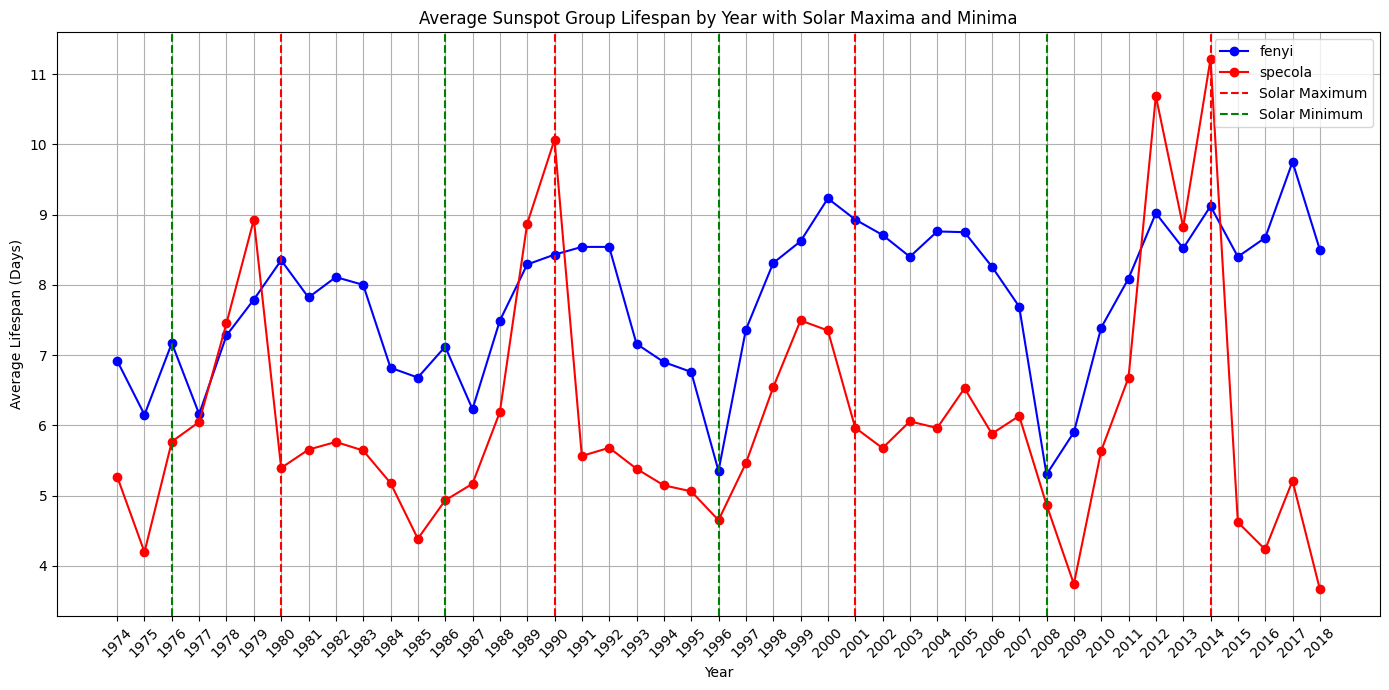

In [18]:
# List of solar maximum and minimum years (example)
solar_maximum_years = ['1980', '1990', '2001', '2014']
solar_minimum_years = ['1976', '1986', '1996', '2008']

# Convert the years in average_lifespan_by_year to strings
average_lifespan_by_year_str = {str(year): value for year, value in average_lifespan_by_year.items()}

# Initialize the test list with values corresponding to list_of_new_years
test = []
for year in list_of_years:
    if year in average_lifespan_by_year_str:
        test.append(average_lifespan_by_year_str[year])
    else:
        test.append(0)  # Append 0 or NaN if there's no data for that year

# Plot both datasets on the same figure
plt.figure(figsize=(14, 7))

# Plot the first set of data
plt.plot(list_of_years, list_of_average_sunspot_lifespan_per_year, marker='o', linestyle='-', color='b', label='fenyi')

# Plot the second set of data
plt.plot(list_of_years, test, marker='o', linestyle='-', color='r', label='specola')

# Add dotted lines for solar maximum years (in red)
for max_year in solar_maximum_years:
    plt.axvline(x=max_year, color='red', linestyle='--', label='Solar Maximum' if max_year == solar_maximum_years[0] else '')

# Add dotted lines for solar minimum years (in green)
for min_year in solar_minimum_years:
    plt.axvline(x=min_year, color='green', linestyle='--', label='Solar Minimum' if min_year == solar_minimum_years[0] else '')

# Add title and labels
plt.title('Average Sunspot Group Lifespan by Year with Solar Maxima and Minima')
plt.xlabel('Year')
plt.ylabel('Average Lifespan (Days)')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

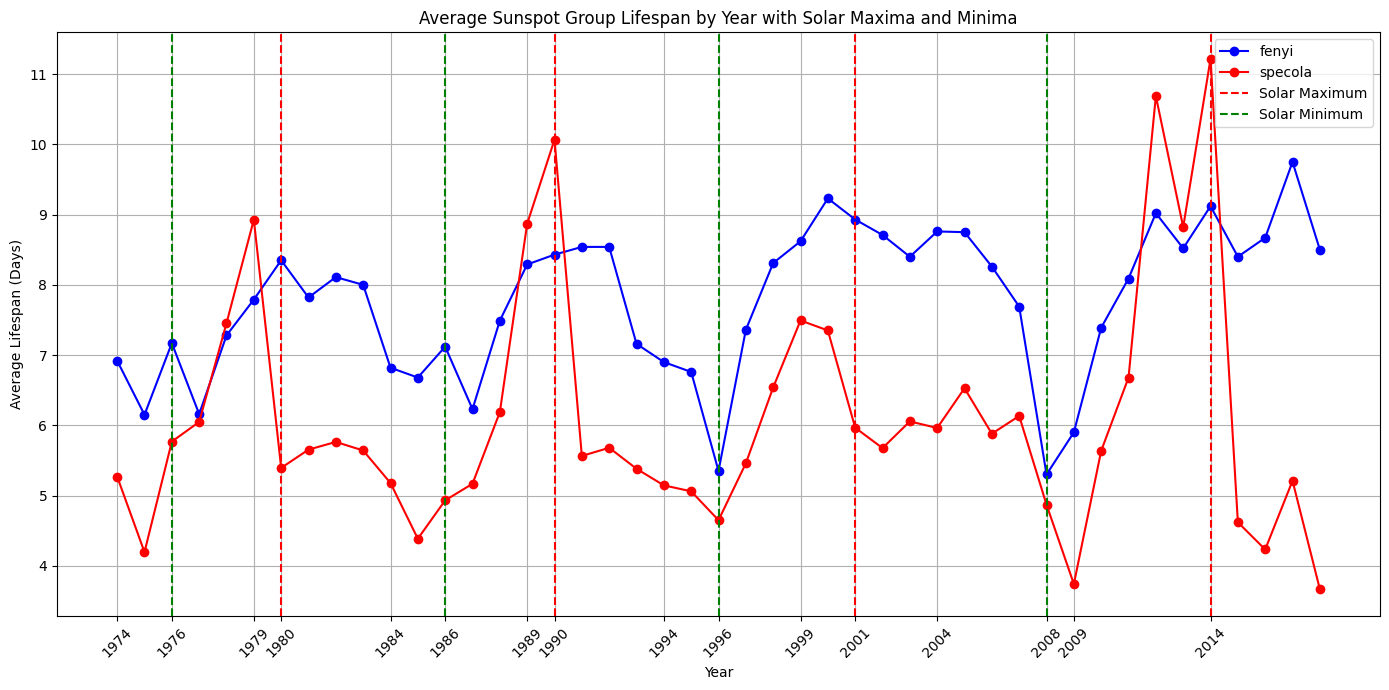

In [19]:
# Generate a list of every 5th year in your dataset
years_to_display = [year for i, year in enumerate(list_of_years) if i % 5 == 0]

# Add solar maximum and minimum years to the list (to ensure they're included)
years_to_display = sorted(set(years_to_display + solar_maximum_years + solar_minimum_years))

# Plot both datasets on the same figure
plt.figure(figsize=(14, 7))

# Plot the first set of data
plt.plot(list_of_years, list_of_average_sunspot_lifespan_per_year, marker='o', linestyle='-', color='b', label='fenyi')

# Plot the second set of data
plt.plot(list_of_years, test, marker='o', linestyle='-', color='r', label='specola')

# Add dotted lines for solar maximum years (in red)
for max_year in solar_maximum_years:
    plt.axvline(x=max_year, color='red', linestyle='--', label='Solar Maximum' if max_year == solar_maximum_years[0] else '')

# Add dotted lines for solar minimum years (in green)
for min_year in solar_minimum_years:
    plt.axvline(x=min_year, color='green', linestyle='--', label='Solar Minimum' if min_year == solar_minimum_years[0] else '')

# Customize x-axis ticks to show every 5th year and solar min/max years
plt.xticks(years_to_display, rotation=45)

# Add title and labels
plt.title('Average Sunspot Group Lifespan by Year with Solar Maxima and Minima')
plt.xlabel('Year')
plt.ylabel('Average Lifespan (Days)')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


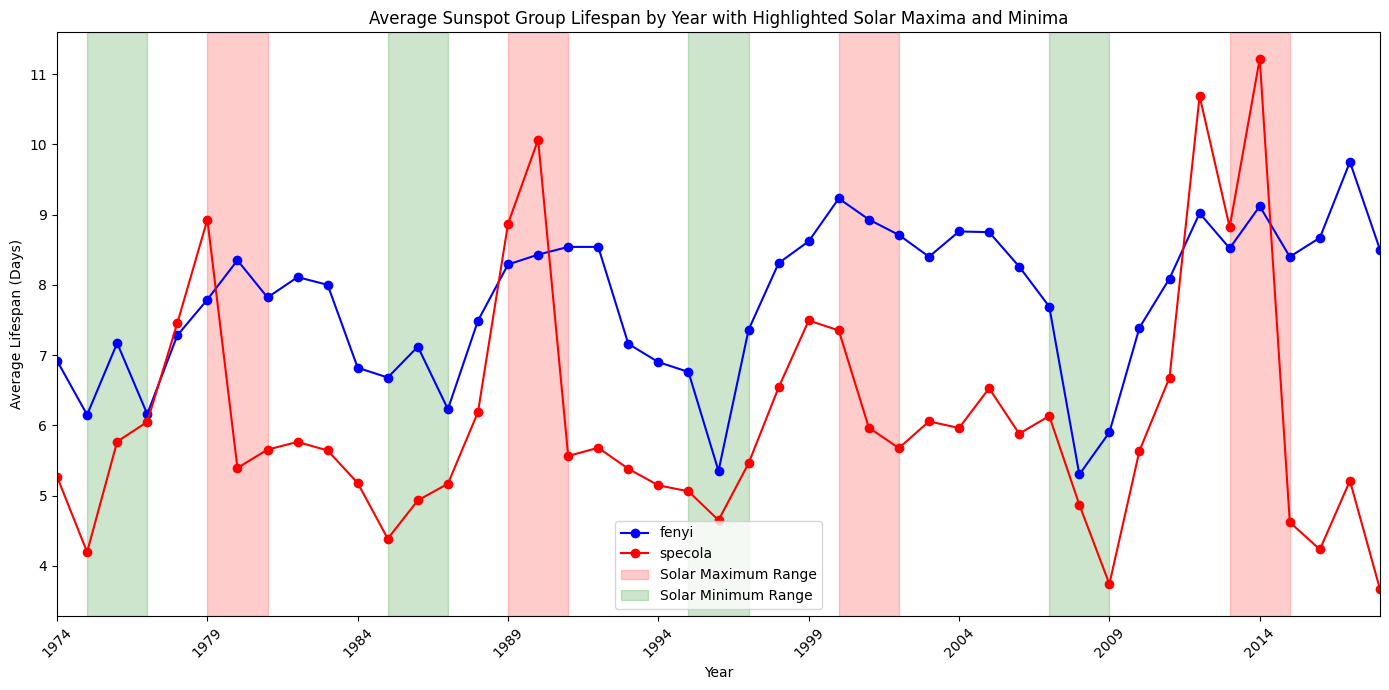

In [20]:
# Convert solar maximum and minimum years to ranges
solar_maximum_ranges = [(int(max_year) - 1, int(max_year) + 1) for max_year in solar_maximum_years]
solar_minimum_ranges = [(int(min_year) - 1, int(min_year) + 1) for min_year in solar_minimum_years]

# Plot both datasets on the same figure
plt.figure(figsize=(14, 7))

# Plot the first set of data
plt.plot(list_of_years, list_of_average_sunspot_lifespan_per_year, marker='o', linestyle='-', color='b', label='fenyi')

# Plot the second set of data
plt.plot(list_of_years, test, marker='o', linestyle='-', color='r', label='specola')

# Highlight solar maximum ranges (in light red)
for start, end in solar_maximum_ranges:
    plt.axvspan(str(start), str(end), color='red', alpha=0.2, label='Solar Maximum Range' if start == int(solar_maximum_years[0]) - 1 else '')

# Highlight solar minimum ranges (in light green)
for start, end in solar_minimum_ranges:
    plt.axvspan(str(start), str(end), color='green', alpha=0.2, label='Solar Minimum Range' if start == int(solar_minimum_years[0]) - 1 else '')

# Add title and labels
plt.title('Average Sunspot Group Lifespan by Year with Highlighted Solar Maxima and Minima')
plt.xlabel('Year')
plt.ylabel('Average Lifespan (Days)')
plt.xlim(min(list_of_years), max(list_of_years))
# plt.grid(True)

# Customize x-axis ticks to show every 5th year and solar min/max years
years_to_display = [year for i, year in enumerate(list_of_years) if i % 5 == 0]
plt.xticks(years_to_display, rotation=45, )

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
directory = "./images"  # Replace with the actual path
filename = "avg sunspot group lifespan by year with highlighted solar maxima and minima.png"
filepath = os.path.join(directory, filename)
plt.savefig(filepath)
plt.show()


In [35]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [37]:
# Find correlation
corelation_max_years = np.array(solar_maximum_years)
corelation_min_years = np.array(solar_minimum_years)

In [39]:
lifespan_max = np.array([9.47,9.19,5.39,10.07,5.97,11.22])
lifespan_min = np.array([3.49,5.77,4.93,4.65,4.87,3.54])
solar_activity_max = np.array([860,583,755,706,563,414])
solar_activity_min = np.array([94,82,73,57,23,28])

"""
The Pearson correlation coefficient [1] measures the linear relationship between two datasets. Like other correlation coefficients,
this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship.
Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
"""

"""
The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson
correlation at least as extreme as the one computed from these datasets.
"""

# Pearson Correlation Solar Max
pearson_corr, p_value_pearson = stats.pearsonr(solar_activity_max, lifespan_max)
pearson_corr_min, p_value_pearson_min = stats.pearsonr(solar_activity_min, lifespan_min)


"""
The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets.
Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply
an exact monotonic relationship. Positive correlations imply that as x increases, so does y.
Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at
least as extreme as the one computed from these datasets. Although calculation of the p-value does not make strong assumptions
about the distributions underlying the samples, it is only accurate for very large samples (>500 observations).
For smaller sample sizes, consider a permutation test (see Examples section below).
"""

# Spearman Correlation
spearman_corr, p_value_spearman = stats.spearmanr(solar_activity_max, lifespan_max)
spearman_corr_min, p_value_spearman_min = stats.spearmanr(solar_activity_min, lifespan_min)

print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {p_value_pearson:.3f}")
print(f"Pearson Correlation Min: {pearson_corr_min:.3f}, p-value: {p_value_pearson_min:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}, p-value: {p_value_spearman:.3f}")
print(f"Spearman Correlation Min: {spearman_corr_min:.3f}, p-value: {p_value_spearman_min:.3f}")

Pearson Correlation: -0.271, p-value: 0.604
Pearson Correlation Min: 0.124, p-value: 0.815
Spearman Correlation: -0.314, p-value: 0.544
Spearman Correlation Min: -0.029, p-value: 0.957


What do these numbers mean?

Pearsons statistic:
From our data we can see that for solar maximums a negative Pearson coorelation with a high p value is saying that as X(solar activity)
increases, Y(lifespan) decrease. This algins with what we already know about solar phenomenom. 

For solar minimum the opposite is true, where with postive correlation, as X(solar activty increase), Y(lifespan) increases. This algins with what we already know about solar phenomenom.




In [ ]:
# do polynomial regression to see if anything comes up, and analyze what that means